In [1]:
"""
EfficientNet-B0 Transfer Learning for Kidney CT Classification
Pretrained backbone (frozen) with custom classifier head
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import timm

# Dynamic device selection: CUDA > MPS > CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
USE_CUDA = device.type == 'cuda'
USE_MPS = device.type == 'mps'

# CUDA-specific optimizations
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"Device: {device}")
if USE_CUDA:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif USE_MPS:
    print("Using Apple Silicon GPU (MPS)")

Device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti


C:\Users\ELJOE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset configuration
CONFIG_PATH = '../data/dataset_config.json'
assert os.path.exists(CONFIG_PATH), "Run 01_data_analysis_processing.ipynb first!"

with open(CONFIG_PATH) as f:
    config = json.load(f)

DATA_PATH = config['data_path']
MEAN, STD = config['mean'], config['std']
IMAGE_SIZE = config['image_size']

# Hyperparameters
OUTPUT_DIR = '../outputs/efficientnet'
MODEL_PATH = os.path.join(OUTPUT_DIR, 'model.pth')
BATCH_SIZE = 128
NUM_WORKERS = 12
EPOCHS = 10
LR = 1e-3
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(f"Data: {DATA_PATH}")
print(f"Normalization - Mean: {MEAN}, Std: {STD}")

Data: c:\Users\ELJOE\Desktop\project\data\processed
Normalization - Mean: [0.14509323239326477, 0.14509248733520508, 0.14509360492229462], Std: [0.2177080661058426, 0.21770790219306946, 0.21770821511745453]


In [ ]:
# Fully cached dataset - all tensors in RAM, augmentation on tensors
class CachedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment=False):
        dataset = datasets.ImageFolder(root)
        self.augment = augment
        self.targets = []
        self.tensors = []
        
        print(f"Caching {len(dataset)} images as tensors...")
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])
        
        for path, target in tqdm(dataset.samples, desc="Loading"):
            img = Image.open(path).convert('RGB')
            tensor = transform(img)
            self.tensors.append(tensor)
            self.targets.append(target)
        
        # Stack into single tensor for faster indexing
        self.tensors = torch.stack(self.tensors)
        self.targets = torch.tensor(self.targets)
        self.classes = dataset.classes
        print(f"Cached tensor shape: {self.tensors.shape}")
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        x = self.tensors[idx]
        if self.augment:
            # Augment directly on tensors (fast)
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [2])  # Horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [1])  # Vertical flip (useful for CT)
        return x, self.targets[idx]

train_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'train'), augment=True)
val_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'val'), augment=False)
test_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'test'), augment=False)

# num_workers=0: Everything cached, no I/O needed
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                         num_workers=0, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"\nClasses: {class_names}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Caching 9411 images as tensors...


Loading: 100%|██████████| 9411/9411 [00:22<00:00, 421.75it/s]


Caching 2017 images as tensors...


Loading: 100%|██████████| 2017/2017 [00:04<00:00, 425.51it/s]


Caching 2017 images as tensors...


Loading: 100%|██████████| 2017/2017 [00:04<00:00, 404.67it/s]


Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Train: 9411 | Val: 2017 | Test: 2017


In [4]:
class KidneyCTClassifier(nn.Module):
    """EfficientNet-B0 with frozen backbone and trainable classifier."""
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(self.backbone(x))

model = KidneyCTClassifier(num_classes).to(device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable:,}")

Trainable parameters: 328,964


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [6]:
# Mixed precision training (CUDA only, MPS/CPU use float32)
scaler = torch.amp.GradScaler(device.type) if USE_CUDA else None
amp_dtype = torch.float16 if USE_CUDA else torch.float32

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    
    for images, labels in tqdm(loader, desc='Train', leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad(set_to_none=True)
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        loss_sum += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    
    for images, labels in tqdm(loader, desc='Eval', leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss_sum += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return loss_sum / total, correct / total

# Warmup pass to initialize GPU kernels
_ = model(torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE, device=device))
if USE_CUDA:
    torch.cuda.synchronize()
elif USE_MPS:
    torch.mps.synchronize()
print("GPU initialized" if device.type != 'cpu' else "Running on CPU")

GPU initialized


In [7]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(), 
                    'class_names': class_names, 'accuracy': best_acc}, MODEL_PATH)
    
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Best: {best_acc:.4f}")

print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}")

Epoch 01/10 | Train: 0.8368 | Val: 0.9296 | Best: 0.9296


Epoch 02/10 | Train: 0.9565 | Val: 0.9707 | Best: 0.9707


Epoch 03/10 | Train: 0.9737 | Val: 0.9817 | Best: 0.9817


Epoch 04/10 | Train: 0.9826 | Val: 0.9836 | Best: 0.9836


Epoch 05/10 | Train: 0.9880 | Val: 0.9851 | Best: 0.9851


Epoch 06/10 | Train: 0.9897 | Val: 0.9901 | Best: 0.9901


Epoch 07/10 | Train: 0.9937 | Val: 0.9901 | Best: 0.9901


Epoch 08/10 | Train: 0.9938 | Val: 0.9906 | Best: 0.9906


Epoch 09/10 | Train: 0.9956 | Val: 0.9911 | Best: 0.9911


Epoch 10/10 | Train: 0.9956 | Val: 0.9911 | Best: 0.9911

Training complete. Best validation accuracy: 0.9911


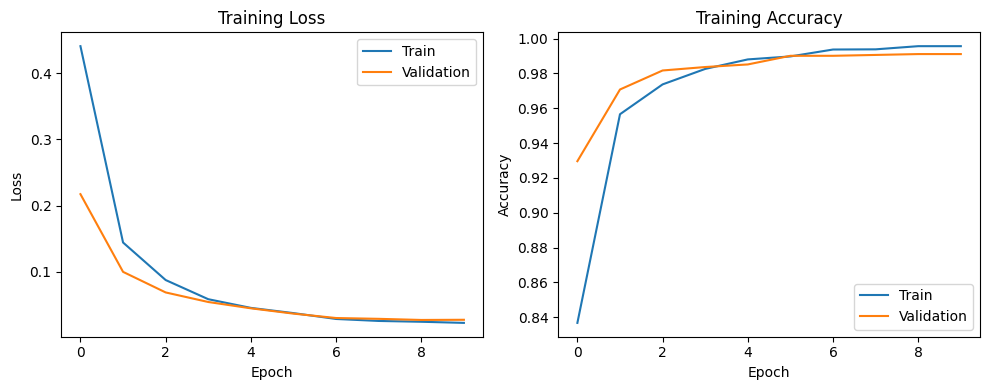

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training Loss')

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

## Test Set Evaluation

Final evaluation on held-out test set (never seen during training).

In [9]:
checkpoint = torch.load(MODEL_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model (validation accuracy: {checkpoint['accuracy']:.4f})")

Loaded best model (validation accuracy: 0.9911)


In [ ]:
test_preds, test_labels_list = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device, non_blocking=True)
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            preds = model(images).argmax(1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.numpy())

print("\nTEST SET RESULTS")
print("=" * 50)
print(classification_report(test_labels_list, test_preds, target_names=class_names))

Testing: 100%|██████████| 8/8 [00:00<00:00, 16.63it/s]


TEST SET RESULTS
              precision    recall  f1-score   support

        Cyst       0.99      0.99      0.99       493
      Normal       1.00      1.00      1.00       750
       Stone       1.00      0.98      0.99       432
       Tumor       0.99      0.99      0.99       342

    accuracy                           0.99      2017
   macro avg       0.99      0.99      0.99      2017
weighted avg       0.99      0.99      0.99      2017



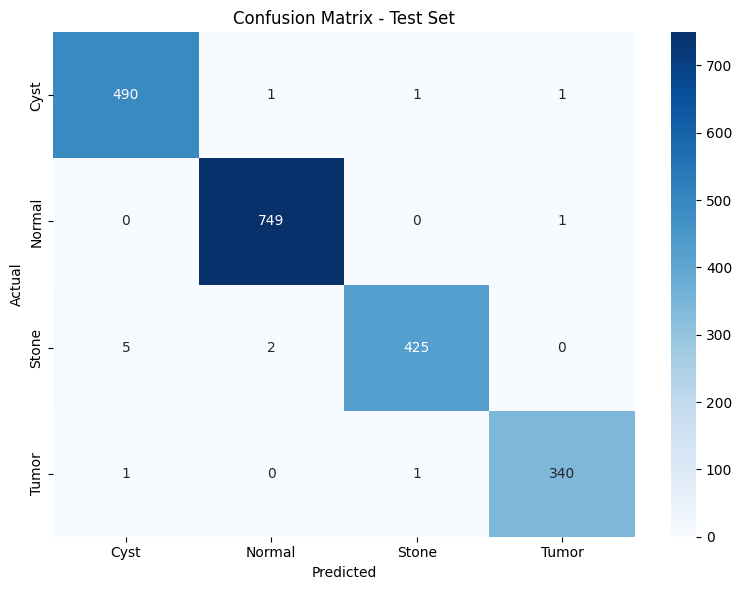

Test Accuracy: 0.9936


In [ ]:
cm = confusion_matrix(test_labels_list, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

test_acc = (np.array(test_preds) == np.array(test_labels_list)).mean()
print(f"Test Accuracy: {test_acc:.4f}")

In [12]:
print("=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Model: EfficientNet-B0 (frozen backbone)")
print(f"Validation Accuracy: {best_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Saved: {MODEL_PATH}")

SUMMARY
Model: EfficientNet-B0 (frozen backbone)
Validation Accuracy: 0.9911
Test Accuracy: 0.9936
Saved: ../outputs/efficientnet\model.pth
